In [1]:
import cv2
import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import pandas as pd
import pytorch_lightning as pl
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from PIL import Image
%matplotlib inline

## Load the data

In [2]:
test_path = './data/chest_xray/'
train_path = './data/chest_xray/'
val_path = './data/chest_xray/'

In [3]:
img_info = pd.read_csv('img_info.csv')
test_df = img_info.loc[img_info.loc[:, 'data'] == 'Test']
train_df = img_info.loc[img_info.loc[:, 'data'] == 'Train']
val_df = test_df = img_info.loc[img_info.loc[:, 'data'] == 'Validation']

In [4]:
# Apply data augmentaion to solve the imbance problem
normal_images = train_df.loc[train_df.loc[:,'label'] == 0]
normal_images.loc[:,'imbalance'] = 1
train_df = pd.concat([train_df, normal_images, normal_images]).reset_index(drop=True)
print('Percentage of Normal Images in the Training Data: {}'.format(
    len(train_df.loc[train_df.loc[:,'label'] == 0])/len(train_df.loc[:,'label'])))
print('Percentage of Pneumonia Images in the Training Data: {}'.format(
    len(train_df.loc[train_df.loc[:,'label'] == 1])/len(train_df.loc[:,'label'])))

Percentage of Normal Images in the Training Data: 0.5093694606229425
Percentage of Pneumonia Images in the Training Data: 0.4906305393770575


/var/folders/rs/dwj3n8716t593gn_r4x21y0r0000gn/T/ipykernel_79588/2152691127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_images.loc[:,'imbalance'] = 1


In [43]:
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir_path, transforms=None):
        """
        You can set your custom dataset to take in more parameters than specified
        here. But, I recommend at least you start with the three I listed here,
        as these are standard

        csv_file (str): file path to the csv file you created /
        df (pandas df): pandas dataframe

        img_dir_path: directory path to your images
        transform: Compose (a PyTorch Class) that strings together several
          transform functions (e.g. data augmentation steps)

        One thing to note -- you technically could implement `transform` within
        the dataset. No one is going to stop you, but you can think of the
        transformations/augmentations you do as a hyperparameter. If you treat
        it as a hyperparameter, you want to be able to experiment with different
        transformations, and therefore, it would make more sense to decide those
        transformations outside the dataset class and pass it to the dataset!
        """
        self.img_labels = df
        self.img_dir = img_dir_path
        self.transforms = transforms
        
    def __len__(self):
        """
        Returns: (int) length of your dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Loads and returns your sample (the image and the label) at the
        specified index

        Parameter: idx (int): index of interest

        Returns: image, label
        """

        img_path =  self.img_dir + self.img_labels.iloc[idx, 1]
        
        image = Image.open(img_path).convert('RGB')

        label = self.img_labels.iloc[idx, -1]
        
        imbalance = self.img_labels.iloc[idx, -2]

        if self.transforms:
            
            if imbalance and not label:
                image = transforms(image)
                image = imbalance_transform(image)
                
            else:
                image = transforms(image)
        else:
            image = tranform_test(image)
               
        return image, label

In [44]:
transforms = T.Compose(
    [
        T.Resize((224,224), antialias=None, interpolation=InterpolationMode.BICUBIC),
        T.RandomApply([
            T.GaussianBlur(kernel_size=(5,5), sigma=(0.1, 0.2))
        ], p=0.5),
        T.RandomEqualize(),
        T.ToTensor()
    ]
)

tranform_test = T.Compose(
    [
        T.Resize((224,224), antialias=None, interpolation=InterpolationMode.BICUBIC),
        T.ToTensor()
    ]
)

imbalance_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomErasing(p=0.2)
])

In [45]:
training_data = CustomImageDataset(train_df, train_path, transforms=transforms)
val_data = CustomImageDataset(val_df, val_path, transforms=transforms)
test_data = CustomImageDataset(test_df, test_path, transforms=None)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [40]:
training_data[0]

(tensor([[[0.0784, 0.0941, 0.0941,  ..., 0.0902, 0.0980, 0.0275],
          [0.0784, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0275],
          [0.0745, 0.0941, 0.0980,  ..., 0.0941, 0.0941, 0.0275],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0784, 0.0941, 0.0941,  ..., 0.0902, 0.0980, 0.0275],
          [0.0784, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0275],
          [0.0745, 0.0941, 0.0980,  ..., 0.0941, 0.0941, 0.0275],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0784, 0.0941, 0.0941,  ..., 0.0902, 0.0980, 0.0275],
          [0.0784, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0275],
          [0.0745, 0.0941, 0.0980,  ...,

## Model Setup - more layers

In [9]:
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [10]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, scheduler=None, EPOCHS=25):
    """
    Train the model and return relevant accuracy metric
    
    Input:
        model: the defined neural network
        criterion: the defined loss func
        optimizer: the defined optimizer
        scheduler: if specified, the learning rate is going to decrease with each epoch
        train_dataloader & val_dataloader: DataLoader object
        EPOCHS: int
    Output:
        model: trained model
        train_losses, train_accuracies, val_losses, val_accuracies: acc metrics
    """

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rate = []

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        # TRAIN
        # Make sure gradient tracking is on, and do a pass over the data
        model.train()
        running_loss = 0.0
        running_matched = 0
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data           # NOTE: depending on how you implemented your dataset class's __getitem__ it could be labels, inputs

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # keep track of the loss
            running_loss += loss.item()

            # CALCULATE ACCURACY METRIC
            preds = torch.argmax(outputs, dim = 1)  # Find out the predicted class with the highest prob
            running_matched += torch.sum(preds == labels.data) # caculate the number of matched labels

        avg_train_loss = running_loss / (i + 1)     # i + 1 gives us the total number of batches in train dataloader
        avg_train_acc = running_matched.double() / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # VALIDATE
        # In the validation part, we don't want to keep track of the gradients 
        model.eval()
        running_val_loss = 0.0
        running_val_matched = 0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # keep track of the loss
                running_val_loss += loss.item()

                # CALCULATE ACCURACY METRIC
                preds = torch.argmax(outputs, dim = 1)
                running_val_matched += torch.sum(preds == labels.data)

        avg_val_loss = running_val_loss / (i + 1)
        avg_val_acc = running_val_matched.double() / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        learning_rate.append(optimizer.param_groups[0]['lr'])
        
        if scheduler != None:
            scheduler.step(avg_val_loss) # add a scheduler to reduce the lr

        # Print epoch summary
        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f} | "
              f"learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
        
    return model, train_losses, train_accuracies, val_losses, val_accuracies, learning_rate


def test(model, test_dataloader):
    """
    Test the data and return test accuracy
    """
    model.eval()
    running_test_matched = 0
    
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim = 1)
            running_test_matched += torch.sum(preds == labels.data)
    
        test_acc = running_test_matched.double() / len(test_dataloader.dataset)
        print(f"Test accuracy: {float(test_acc):.4f}")

    return test_acc


In [11]:
import json

def write_model_and_results(model, 
                            train_losses, 
                            train_accuracies, 
                            val_losses, 
                            val_accuracies,
                            learning_rate,
                            path):
    """
    Save the model and results
    
    Inputs:
        path: a list of str containing the path for model and the path for results
    """

    train_acc = [float(i) for i in train_accuracies]
    val_acc = [float(i) for i in val_accuracies]

    result = {'train_losses': train_losses,
             'train_accuracies': train_acc,
             'val_losses': val_losses,
             'val_accuracies': val_acc,
             'learning_rates': learning_rate}
    
    # save model
    torch.save(model.state_dict(), path[0])
    # save results
    with open(path[1], 'w') as f:
        f.write(json.dumps(result))
        

### Sample Model Construction

Here shows the training precess for the CNN with ReLU as the activation function and Negative Loss Likelihood as the loss function.

In [12]:
class CustomNeuralNetwork_relu(nn.Module):
    def __init__(self, dropout_rate=0.6):
        super().__init__()
        
        self.LeNet = nn.Sequential(     
            # convolutional layers            
            nn.Sequential(                                            # FIRST LAYER: (INPUT LAYER)
              nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=0),    # CONVOLUTION 
              nn.BatchNorm2d(6),
              nn.ReLU(),
              nn.Dropout(p=dropout_rate),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
           
            nn.Sequential(                                            # SECOND LAYER: HIDDEN LAYER 1
              nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),   # CONVOLUTION 
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(p=dropout_rate),
              nn.MaxPool2d(kernel_size = 2, stride = 2)),             # POOLING
            
          # POOLING
            # fully connected layers
            nn.Flatten(),
            
            nn.Linear(16 * 54 * 54, 256),
            nn.ReLU(),
            
            nn.Linear(256, 32),
            nn.ReLU(),
            
            
        # output layer
            nn.Linear(32, 2)                                            # OUTPUT LAYER
        )

    def forward(self, x):
        out = self.LeNet(x)
        return F.log_softmax(out, dim=1)

In [13]:
model_relu = CustomNeuralNetwork_relu()

In [14]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model_relu.parameters(), lr=0.001, momentum=0.9)

# Inspired by: https://hasty.ai/docs/mp-wiki/scheduler/reducelronplateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=2, 
                                                 threshold=0.0001, 
                                                 threshold_mode='rel', 
                                                 cooldown=0, 
                                                 min_lr=0, 
                                                 eps=1e-08)

In [15]:
# I interupt running after this first epoch, feel free to continue run it
model_relu, train_losses, train_accuracies, val_losses, val_accuracies, learning_rate = train(model_relu, 
                                                                                              criterion, 
                                                                                              optimizer,
                                                                                              train_dataloader, 
                                                                                              val_dataloader, 
                                                                                              scheduler,
                                                                                              EPOCHS=15)

Epoch 1/15 | Train Loss: 0.1929, Train Acc: 0.9261 | Val Loss: 0.4966, Val Acc: 0.8125 | learning rate: 0.0010
Epoch 2/15 | Train Loss: 0.0900, Train Acc: 0.9649 | Val Loss: 0.4497, Val Acc: 0.8125 | learning rate: 0.0010
Epoch 3/15 | Train Loss: 0.0676, Train Acc: 0.9748 | Val Loss: 0.3373, Val Acc: 0.9375 | learning rate: 0.0010
Epoch 4/15 | Train Loss: 0.0639, Train Acc: 0.9764 | Val Loss: 0.4021, Val Acc: 0.8750 | learning rate: 0.0010
Epoch 5/15 | Train Loss: 0.0459, Train Acc: 0.9828 | Val Loss: 0.3155, Val Acc: 0.9375 | learning rate: 0.0010
Epoch 6/15 | Train Loss: 0.0416, Train Acc: 0.9851 | Val Loss: 0.3383, Val Acc: 0.8750 | learning rate: 0.0010
Epoch 7/15 | Train Loss: 0.0413, Train Acc: 0.9853 | Val Loss: 0.3977, Val Acc: 0.8125 | learning rate: 0.0010
Epoch 8/15 | Train Loss: 0.0375, Train Acc: 0.9863 | Val Loss: 0.3414, Val Acc: 0.9375 | learning rate: 0.0005
Epoch 9/15 | Train Loss: 0.0242, Train Acc: 0.9914 | Val Loss: 0.3963, Val Acc: 0.8750 | learning rate: 0.0005
E

In [46]:
test(model_relu, test_dataloader)

Test accuracy: 0.8125


tensor(0.8125, dtype=torch.float64)

In [26]:
acc_dict
acc_dict_5L = {0.8125: 14, 0.875: 40, 0.9375: 35,1.0: 11}

In [19]:
path = ['model_new_5L.PT', 'result_new_5L.txt']
write_model_and_results(model_relu, train_losses, train_accuracies, val_losses, val_accuracies, learning_rate,path)

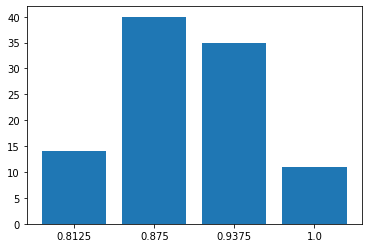

In [27]:
import matplotlib.pyplot as plt

data = acc_dict_5L
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

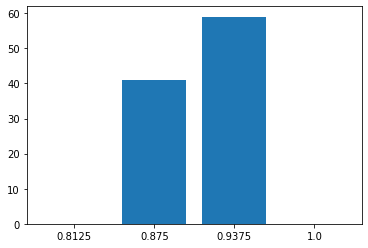

In [28]:
import matplotlib.pyplot as plt

data =  {0.8125:0, 0.875: 41, 0.9375: 59, 1:0}
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

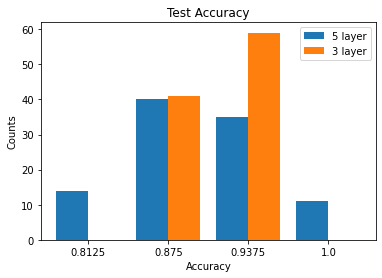

In [33]:
import numpy as np
data =  {0.8125:0, 0.875: 41, 0.9375: 59, 1:0}
X = acc_dict_5L.keys()
layer_5 = acc_dict_5L.values()
layer_3 = data.values()
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, layer_5, 0.4, label = '5 layer')
plt.bar(X_axis + 0.2, layer_3, 0.4, label = '3 layer')
  
plt.xticks(X_axis, X)
plt.xlabel("Accuracy")
plt.ylabel("Counts")
plt.title("Test Accuracy")
plt.legend()
plt.show()

## Analysis

**Note:** We incorporate all the accuracy metrics generated by the trained models into two files: CNN_crossentropy_output.txt and CNN_NLL_output.txt